In [2]:
# Para visuzalización en notebook
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.cm as cm


mpl.rcParams['figure.figsize'] = (8,6)
mpl.rcParams['font.size'] = 22
from IPython.display import Audio, Markdown, Image
import seaborn as sns

# Números y Datos
import numpy as np
import pandas as pd

# Archivos
import urllib.request
import glob

# Machine learning
# importar los paquetes para clustering


In [3]:
import random
import csv
import scipy.stats as st
from scipy.stats import zscore

from sklearn.cluster import KMeans, AgglomerativeClustering
from sklearn.metrics import adjusted_rand_score, silhouette_samples, silhouette_score

from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz

from sklearn.neighbors import NearestNeighbors
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler




# Trabajo Práctico 1

# Integrantes:
- Emiliano Beltrame
- Martin Castro
- Javier Alonso Duque
- Lucas Pecina

## Carga y preprocesamiento:
### Carga metadata, audio_features y audio_analysis
En primer lugar cargamos los 3 conjuntos de datos que tenemos disponibles para trabajar

In [21]:
metadata = pd.read_csv('metadata.csv', index_col='id')
audio_features = pd.read_csv('audio_features.csv', index_col='id')

audio_timbre_files = glob.glob('audio_analysis/timbre/*')
audio_timbre = []
for filename in audio_timbre_files:
    audio_timbre.append( pd.read_csv(filename, index_col='start') )
    
audio_pitches_files = glob.glob('audio_analysis/pitches/*')
audio_pitches = []
for filename in audio_pitches_files:
    audio_pitches.append( pd.read_csv(filename, index_col='start') )

## Clustering
### Primera aproximacion KMeans
Utilizando solo las variables continuas realizamos un primer clustering de KMeans
Lo realizaremos con los datos de audio_features y audio_analysis por separado y luego en conjunto.

Buscaremos el k optimo con los metodos de SSE y Silhouette

#### Realizamos el filtrado de variables numericas para Audio Features (AF)

In [6]:
#audio_features.head()
#Selecciono las variables numericas
audio_features_filtro=audio_features[['acousticness','danceability','duration_ms','energy','instrumentalness','key',
                                      'liveness','loudness','mode','speechiness','tempo','time_signature']]

af_std=audio_features_filtro.apply(zscore)
af_std.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature
id,,,,,,,,,,,,
5i2sgqnzaxYpvXmGAB592h,1.020239,0.449745,-0.392481,-1.029845,-1.300295,-1.488774,-0.231088,-0.516235,0.903954,-0.205105,0.212158,0.303630
4mGzm5ahHxMX5IhVWbU7cl,1.010052,0.221832,-0.417492,-1.265002,-1.303436,-0.355693,-0.488797,-1.178182,0.903954,0.002865,0.041103,0.303630
4DEn3hZzSs9MFwFNDla5Y5,1.101731,-0.223633,-0.806927,-0.899546,1.022131,-0.072423,1.044891,-0.854780,-1.106251,-0.467408,-0.620113,-1.556946
5P6vo51dtkBYWXswH1twvK,-0.973784,0.123415,1.992726,1.033216,0.494522,1.060659,3.244854,0.466306,-1.106251,1.625400,0.270690,2.164206
29TZQMVLv25CBm3bYn2EIQ,-0.306563,0.076797,0.048504,0.189378,1.001641,1.343929,-0.413370,0.120310,-1.106251,-0.512374,-0.249576,0.303630


#### Realizamos el filtrado de variables numericas para Audio Analysis - Timbre (AT)

Este conjunto de datos contine las variables continuas de bajo nivel estimadas en vetanas temporales. Dado que las canciones tienen distintas duraciones, lo que se hace es calcular el promedio de las variables por canciones.

In [59]:
items = []
items_1={}
for i in range(0,len(audio_timbre)):
    #items.append(audio_analysis[i].mean())
    items_1=np.transpose(pd.DataFrame(audio_timbre[i].mean()))
    items.append(items_1)

audio_timbre_filtro=pd.concat(items)

at_std = audio_timbre_filtro.apply(zscore)
at_std.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.684559,1.427134,0.878156,0.913863,1.235725,-0.374374,0.039880,0.240994,-0.248528,1.310129,-0.307511,-0.515035
0,1.567751,1.117248,-0.332077,0.155590,0.587707,-1.157032,0.200848,-0.119834,-1.391049,0.084937,0.002993,-0.117212
0,-0.671032,-0.721798,1.012578,-0.316574,0.488246,0.042984,0.116986,-0.119672,1.753290,-0.440985,0.047073,-1.416465
0,-1.844885,-1.333698,0.387999,0.404079,2.580445,0.085515,-1.081328,0.586926,-1.441948,-0.779218,0.946592,-0.851020
0,0.729677,0.868692,0.474267,1.231448,-0.114804,-1.270126,1.369950,-0.130370,-1.709034,-0.501788,1.009422,1.092649


#### Realizamos el filtrado de variables numericas para Audio Analysis - Pitches (AP)

Este conjunto de datos contine las variables continuas de bajo nivel estimadas en vetanas temporales. Dado que las canciones tienen distintas duraciones, lo que se hace es calcular el promedio de las variables por canciones.

In [22]:
items = []
items_1={}
for i in range(0,len(audio_pitches)):
    #items.append(audio_analysis[i].mean())
    items_1=np.transpose(pd.DataFrame(audio_pitches[i].mean()))
    items.append(items_1)

audio_pitches_filtro=pd.concat(items)

ap_std = audio_pitches_filtro.apply(zscore)
ap_std.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,-0.163708,2.286403,-0.188288,0.109625,-0.239415,-0.521668,0.048891,-0.913262,0.641345,-0.121200,0.090180,0.689190
0,-0.944052,0.962279,-1.277754,-0.903239,-0.190082,-0.775363,0.865136,-0.351856,1.680782,0.873869,0.126767,-0.252931
0,-0.186601,0.930250,-0.551872,0.921459,-0.835259,0.254722,-0.216559,-0.542039,0.568448,-0.854792,0.335112,-1.038388
0,-1.597771,-0.837897,-1.790941,0.120450,-1.342012,-1.011316,-1.293502,-1.778088,3.426587,-1.860814,-1.396560,-1.084502
0,0.840882,-0.091534,0.656248,2.093936,0.283446,0.277896,0.743704,2.045332,0.718308,0.067099,0.874008,-0.217445


#### Realizamos la union de AT & AP en un unico dataset (AA)

In [24]:
#len(af_std)
#len(aa_std)
# Ambos datasets tienen distinta dimension.
# Adicionalmente estan desordenados, procedemos a unirlos por el ID
files_at=pd.DataFrame(audio_timbre_files)
files_at['id']=files_at[0].str.replace('audio_analysis\/timbre\\\\', '')
files_at['id']=files_at['id'].str.replace('.csv', '')
files_at.set_index('id', inplace=True)

files_ap=pd.DataFrame(audio_pitches_files)
files_ap['id']=files_ap[0].str.replace('audio_analysis\/pitches\\\\', '')
files_ap['id']=files_ap['id'].str.replace('.csv', '')
files_ap.set_index('id', inplace=True)

at_std.index=files_at.index
at_std.columns = ['t0', 't1','t2','t3','t4','t5','t6','t7','t8','t9','t10','t11']
at_std.head()

ap_std.index=files_ap.index
ap_std.columns = ['p0', 'p1','p2','p3','p4','p5','p6','p7','p8','p9','p10','p11']
ap_std.head()

aa_std=pd.merge(at_std, ap_std, left_index=True, right_index=True)
aa_std.head()

,0
id,
00At7PWydsvg7g5xgaYan9,audio_analysis/timbre\00At7PWydsvg7g5xgaYan9.csv
00BgcUYkIImsDN5rNjkR1U,audio_analysis/timbre\00BgcUYkIImsDN5rNjkR1U.csv
00isAURAZeKQXv6CW2vckb,audio_analysis/timbre\00isAURAZeKQXv6CW2vckb.csv
00ne3qRgc0JqY6MNYfhWri,audio_analysis/timbre\00ne3qRgc0JqY6MNYfhWri.csv
00WgnFIsY1y84p7mYAJRuF,audio_analysis/timbre\00WgnFIsY1y84p7mYAJRuF.csv


#### Realizamos la union de AF & AA en un unico dataset

In [30]:
#len(af_std)
#len(aa_std)
# Ambos datasets tienen distinta dimension.
# Adicionalmente estan desordenados, procedemos a unirlos por el ID
df=pd.merge(af_std, aa_std, left_index=True, right_index=True)
df.head()

,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,...,p2,p3,p4,p5,p6,p7,p8,p9,p10,p11
id,,,,,,,,,,,,,,,,,,,,,
5i2sgqnzaxYpvXmGAB592h,1.020239,0.449745,-0.392481,-1.029845,-1.300295,-1.488774,-0.231088,-0.516235,0.903954,-0.205105,...,0.429194,-0.964090,0.192580,-0.307125,-1.056667,-0.668528,-0.885907,-0.484121,-1.119978,-0.541615
4mGzm5ahHxMX5IhVWbU7cl,1.010052,0.221832,-0.417492,-1.265002,-1.303436,-0.355693,-0.488797,-1.178182,0.903954,0.002865,...,-1.261179,-0.280173,-0.201627,-1.068389,-0.289839,-1.165009,0.027200,-0.475848,-0.952153,1.042061
4DEn3hZzSs9MFwFNDla5Y5,1.101731,-0.223633,-0.806927,-0.899546,1.022131,-0.072423,1.044891,-0.854780,-1.106251,-0.467408,...,-0.909609,0.041257,-0.940016,0.480191,-0.963253,0.160374,0.385666,-1.089725,0.559197,0.005162
5P6vo51dtkBYWXswH1twvK,-0.973784,0.123415,1.992726,1.033216,0.494522,1.060659,3.244854,0.466306,-1.106251,1.625400,...,0.910074,0.731357,1.696521,0.380479,0.282595,0.627694,0.489419,1.297319,0.804486,1.681947
29TZQMVLv25CBm3bYn2EIQ,-0.306563,0.076797,0.048504,0.189378,1.001641,1.343929,-0.413370,0.120310,-1.106251,-0.512374,...,0.323621,1.707393,0.812207,0.423909,-0.018004,-0.120965,0.074117,-0.263090,0.312169,-0.668375


#### Realizamos calculo de SSE

In [33]:
#inicializo tres SSE: 
sse_af = {}
sse_aa = {}
sse_df = {}
for k in range(1, 30):
    kmeans = KMeans(n_clusters=k, init='random',n_init=5,max_iter=500, random_state=0)
    kmeans.fit(af_std)
    sse_af[k] = kmeans.inertia_
    kmeans.fit(aa_std)
    sse_aa[k] = kmeans.inertia_
    kmeans.fit(df)
    sse_df[k] = kmeans.inertia_

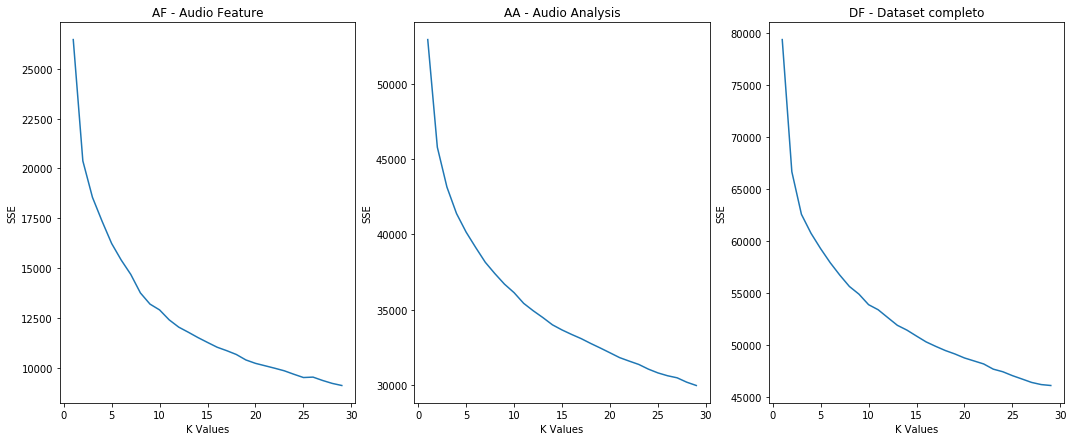

<Figure size 432x288 with 0 Axes>

In [34]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.plot(list(sse_af.keys()), list(sse_af.values()))
g1.set_title("AF - Audio Feature")
g1.set_xlabel("K Values")
g1.set_ylabel("SSE")
g2.plot(list(sse_aa.keys()), list(sse_aa.values()))
g2.set_title("AA - Audio Analysis")
g2.set_xlabel("K Values")
g2.set_ylabel("SSE")
g3.plot(list(sse_df.keys()), list(sse_df.values()))
g3.set_title("DF - Dataset completo")
g3.set_xlabel("K Values")
g3.set_ylabel("SSE")
plt.show()

Considerando el metodo del codo se puede decir que el numero optimo estaria en torno a k = 10

#### Realizamos el calculo por metodo de Silhouette

In [35]:
slh_af = {}
slh_aa = {}
slh_df = {}
for k in range(2, 21):
    kmeans = KMeans(n_clusters=k, init='random',n_init=5,max_iter=500, random_state=0)
    kmeans.fit(af_std)
    label = kmeans.labels_
    slh_af[k] = silhouette_score(af_std, label, metric='euclidean')
    kmeans.fit(aa_std)
    label = kmeans.labels_
    slh_aa[k] = silhouette_score(aa_std, label, metric='euclidean')
    kmeans.fit(df)
    label = kmeans.labels_
    slh_df[k] = silhouette_score(df, label, metric='euclidean')

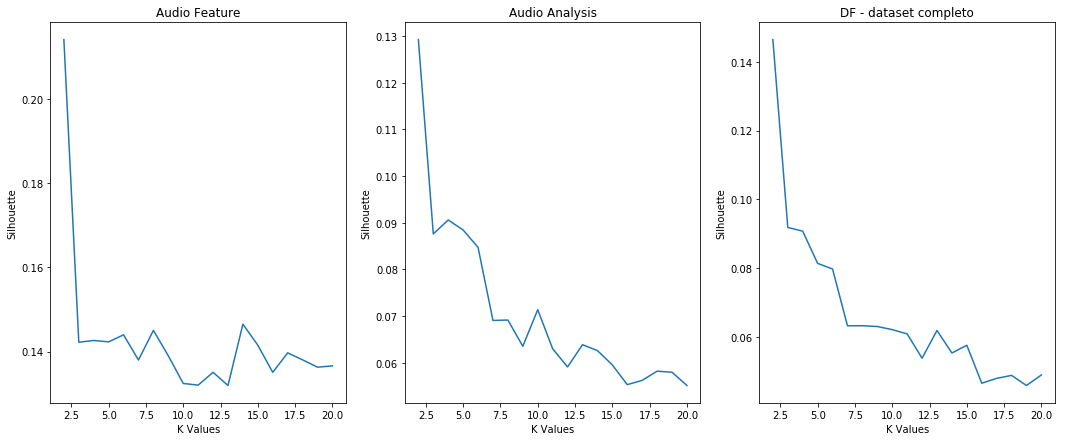

<Figure size 432x288 with 0 Axes>

In [36]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.plot(list(slh_af.keys()), list(slh_af.values()))
g1.set_title("Audio Feature")
g1.set_xlabel("K Values")
g1.set_ylabel("Silhouette")
g2.plot(list(slh_aa.keys()), list(slh_aa.values()))
g2.set_title("Audio Analysis")
g2.set_xlabel("K Values")
g2.set_ylabel("Silhouette")
g3.plot(list(slh_df.keys()), list(slh_df.values()))
g3.set_title("DF - dataset completo")
g3.set_xlabel("K Values")
g3.set_ylabel("Silhouette")
plt.show()

Considerando Silhouette tambien se ve que el K optimo esta en torno a 8.

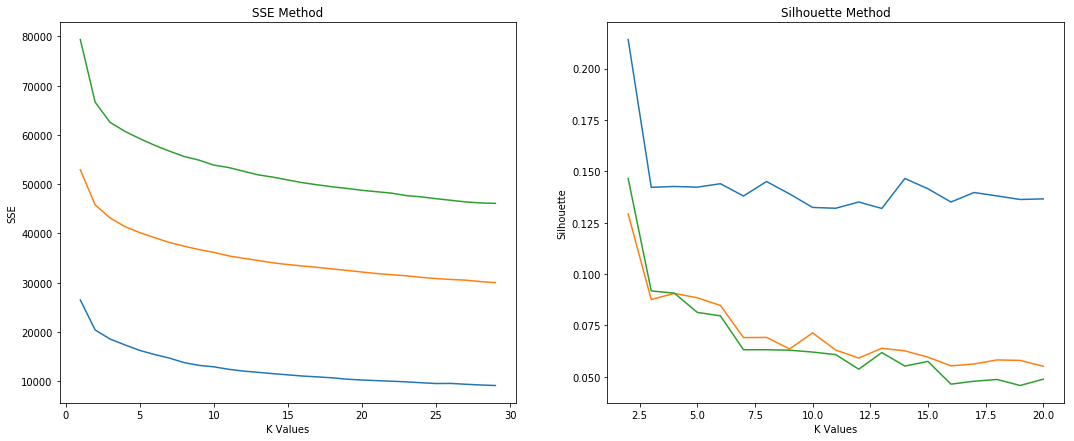

<Figure size 432x288 with 0 Axes>

In [37]:
# VUELVO A GRAFICAR PERO EN UNO SOLO
# COMPARATIVO QUIZAS ES MAS VISUAL
fig, (g1, g2) = plt.subplots(1, 2)
fig.set_size_inches(18, 7)    

plt.figure()
g1.plot(list(sse_af.keys()), list(sse_af.values()))
g1.plot(list(sse_aa.keys()), list(sse_aa.values()))
g1.plot(list(sse_df.keys()), list(sse_df.values()))
g1.set_title("SSE Method")
g1.set_xlabel("K Values")
g1.set_ylabel("SSE")
g2.plot(list(slh_af.keys()), list(slh_af.values()))
g2.plot(list(slh_aa.keys()), list(slh_aa.values()))
g2.plot(list(slh_df.keys()), list(slh_df.values()))
g2.set_title("Silhouette Method")
g2.set_xlabel("K Values")
g2.set_ylabel("Silhouette")
plt.show()

For k = 6 The average silhouette_score is : 0.14396359535475536
For k = 7 The average silhouette_score is : 0.1379783634182604
For k = 8 The average silhouette_score is : 0.14502103809096356
For k = 9 The average silhouette_score is : 0.13898681962012832
For k = 10 The average silhouette_score is : 0.13241077880388388


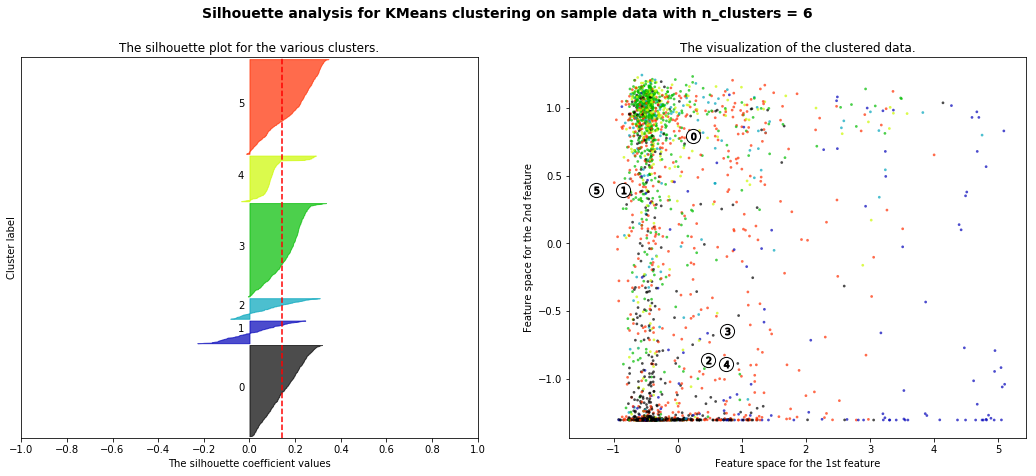

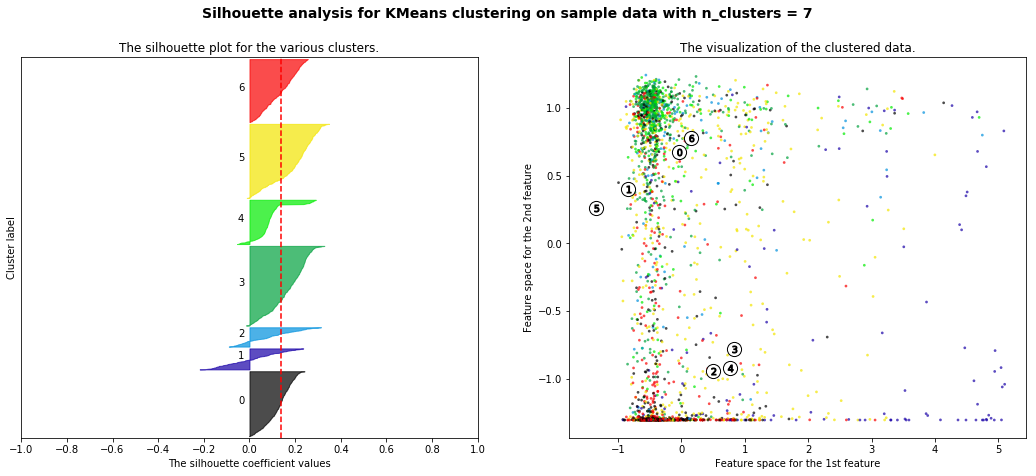

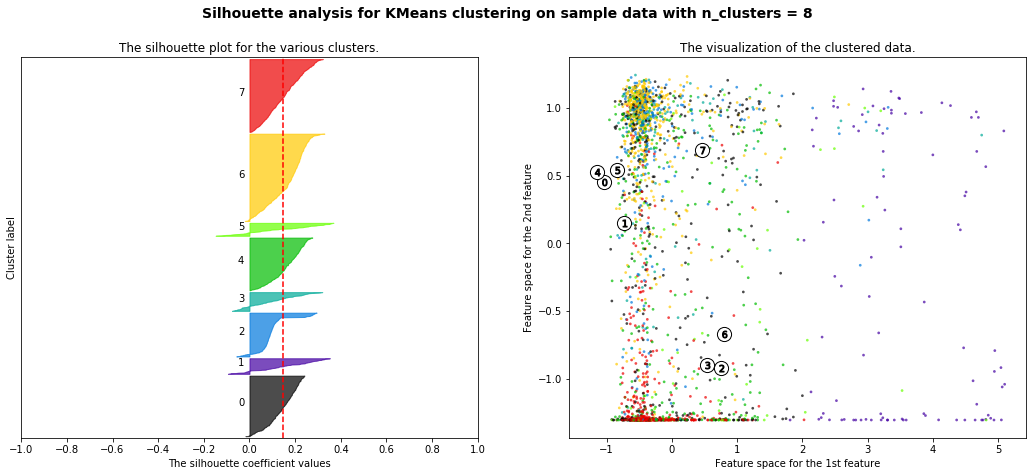

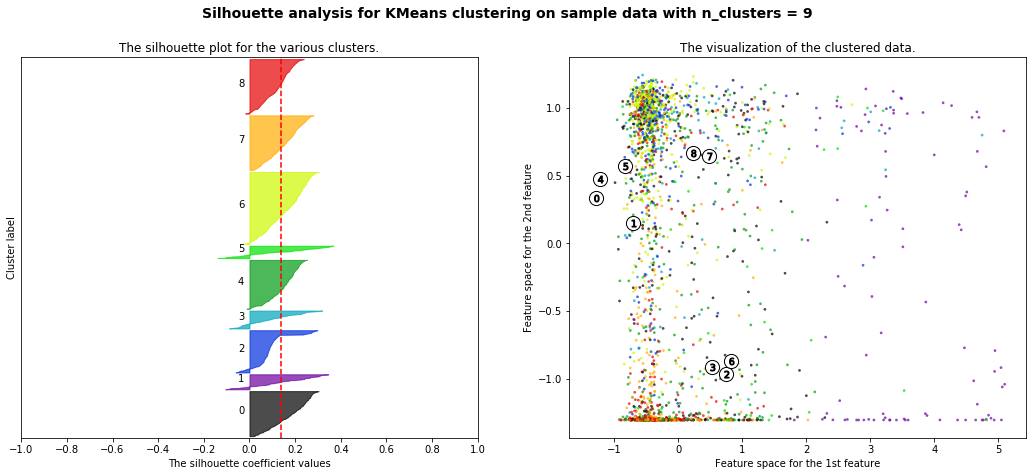

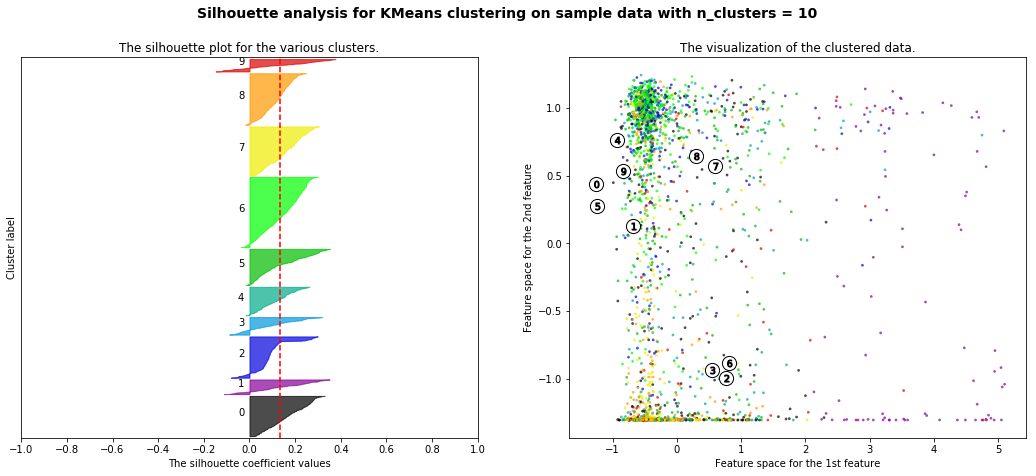

In [38]:
# Para graficar como se compone el silhouette a lo largo del cluster -solo 1 dataset
range_n_clusters = [ 6, 7, 8, 9, 10]

for k in range_n_clusters:
    # Create a subplot with 1 row and 2 columns
    fig, (ax1, ax2) = plt.subplots(1, 2)
    fig.set_size_inches(18, 7)

    # The 1st subplot is the silhouette plot
    ax1.set_xlim([-1, 1])
    # plots of individual clusters, to demarcate them clearly.
    ax1.set_ylim([0, len(af_std) + (k + 1) * 10])

    # Initialize the cluster
    kmeans = KMeans(n_clusters=k, init='random',n_init=5,max_iter=500, random_state=0)
    cluster_labels = kmeans.fit_predict(af_std)

    # The silhouette_score
    silhouette_avg = silhouette_score(af_std, cluster_labels, metric='euclidean')
    print("For k =", k,
          "The average silhouette_score is :", silhouette_avg)

    # Compute the silhouette scores for each sample
    sample_silhouette_values = silhouette_samples(af_std, cluster_labels)

    y_lower = 10
    for i in range(k):
        # Aggregate the silhouette scores for samples belonging to
        # cluster i, and sort them
        ith_cluster_silhouette_values = \
            sample_silhouette_values[cluster_labels == i]

        ith_cluster_silhouette_values.sort()

        size_cluster_i = ith_cluster_silhouette_values.shape[0]
        y_upper = y_lower + size_cluster_i

        color = cm.nipy_spectral(float(i) / k)
        ax1.fill_betweenx(np.arange(y_lower, y_upper),
                          0, ith_cluster_silhouette_values,
                          facecolor=color, edgecolor=color, alpha=0.7)

        # Label the silhouette plots with their cluster numbers at the middle
        ax1.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

        # Compute the new y_lower for next plot
        y_lower = y_upper + 10  # 10 for the 0 samples

    ax1.set_title("The silhouette plot for the various clusters.")
    ax1.set_xlabel("The silhouette coefficient values")
    ax1.set_ylabel("Cluster label")

    # Plote the average silhouette score
    ax1.axvline(x=silhouette_avg, color="red", linestyle="--")

    ax1.set_yticks([])  # Clear the yaxis labels / ticks
    ax1.set_xticks([-1,-0.8,-0.6,-0.4,-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1])

    # 2nd Plot showing the actual clusters formed
    colors = cm.nipy_spectral(cluster_labels.astype(float) / k)
    ax2.scatter(af_std.iloc[:, 6], af_std.iloc[:, 4], marker='.', s=30, lw=0, alpha=0.7,
                c=colors, edgecolor='k')

    # Labeling the clusters
    centers = kmeans.cluster_centers_
    # Draw white circles at cluster centers
    ax2.scatter(centers[:, 0], centers[:, 1], marker='o',
                c="white", alpha=1, s=200, edgecolor='k')

    for i, c in enumerate(centers):
        ax2.scatter(c[0], c[1], marker='$%d$' % i, alpha=1,
                    s=50, edgecolor='k')

    ax2.set_title("The visualization of the clustered data.")
    ax2.set_xlabel("Feature space for the 1st feature")
    ax2.set_ylabel("Feature space for the 2nd feature")

    plt.suptitle(("Silhouette analysis for KMeans clustering on sample data "
                  "with n_clusters = %d" % k),
                 fontsize=14, fontweight='bold')

plt.show()

Se determina que la optima cantidad de cluster son 8. 

#### Ahora procedemos a hacer los cluster con K-Means y obtenemos su matriz de confusion y otras medidas de similaridad

#### Aplicacion de K-Means y evaluación de similitud

Procedemos aplicar el metodo K-Means con el K = 8 para los tres datasets (AF, AA y DF).
Transformamos el espacio de los datasets mediante componentes principales para una visualizacion grafica de los resultados

In [50]:
dataframes = ['af_std','at_std','ap_std','aa_std','df']
princomp = PCA(n_components=2)
result = {}
for data in dataframes:
    kmeans = KMeans(n_clusters=6, init='random',n_init=5,max_iter=500, random_state=0)
    kmeans.fit(eval(data))
    label = kmeans.labels_
    pca = princomp.fit(eval(data)).transform(eval(data))
    pca = pd.DataFrame(pca)
    pca.index = eval(data).index
    pca['label'] = label
    result[data]=pca
    

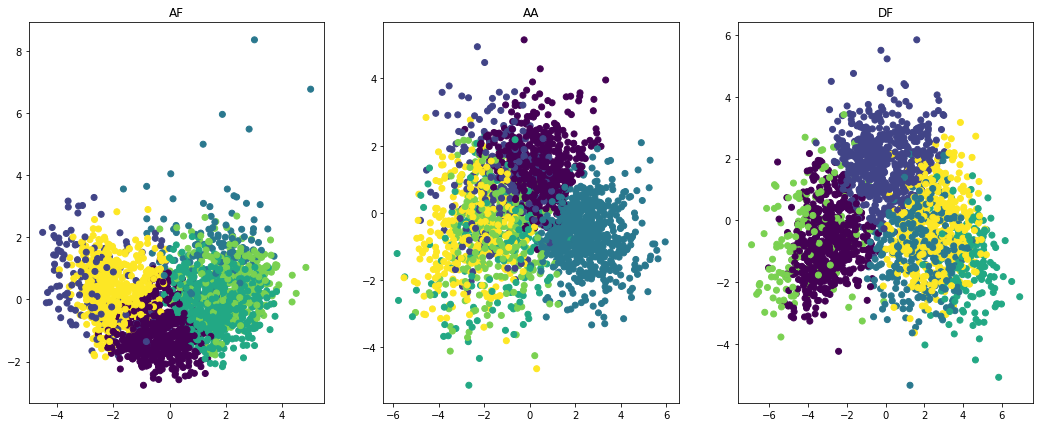

<Figure size 432x288 with 0 Axes>

In [51]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.scatter(result['af_std'].iloc[:, 0], result['af_std'].iloc[:, 1], c=result['af_std'].iloc[:, 2])
g2.scatter(result['aa_std'].iloc[:, 0], result['aa_std'].iloc[:, 1], c=result['aa_std'].iloc[:, 2])
g3.scatter(result['df'].iloc[:, 0], result['df'].iloc[:, 1], c=result['df'].iloc[:, 2])
g1.set_title("AF")
g2.set_title("AA")
g3.set_title("DF")
plt.show()

(Revisar este comentario)
Graficamente se puede observar que el clustering arrojado por DF (conjunto completo) esta mas proximo a AA ??

#### Calculamos el coef. Hopkins para los datasets


In [52]:
def Hopkins(df,*args):
    n = df.shape[0] # filas
    d = df.shape[1] # columnas
    if not args:
        #print("Numero de puntos al azar por defecto")
        m = int(0.1 * n) # cantidad de puntos al azar (default)
    else:
        m = args[0] # cantidad de puntos al azar

    nbrs = NearestNeighbors(n_neighbors=1, algorithm='brute').fit(df) # buscador de vecinos

    rand_ind = random.sample(range(0, n, 1), m) # indices al azar

    ui = []
    wi = []
    for j in range(0, m):
        u_dist, _ = nbrs.kneighbors(np.random.normal(size=(1, d)).reshape(1, -1), 2, return_distance=True) # distancia a los nuevos puntos
        ui.append(u_dist[0][1])
        w_dist, _ = nbrs.kneighbors(df[rand_ind[j]].reshape(1, -1), 2, return_distance=True) # distancia a los puntos al azar
        wi.append(w_dist[0][1])

    H = sum(wi) / (sum(ui) + sum(wi))
    return H

print("af_std =",Hopkins(af_std.values))
print("aa_std =",Hopkins(aa_std.values))
print("df =",Hopkins(df.values))

af_std = 0.33270148026713886
aa_std = 0.41917011045926234
df = 0.4180026706663409


Observamos que el dataset de Audio Features tiene mayor tendencia al Clustering pues su valor es mas proximo a 0.
(Si sum(u) ~ sum(w) entonces H ~ 0.5. En cambio, si sum(u) >> sum(w), entonces están menos agrupados los que se encuentran al azar, luego H << 0.5.)

#### Calculamos el coef. Van Dongen para los datasets

Si bien el metodo de Van Dongen esta pensado para una validación externa contra una clase, en este caso lo usaremos para comparar cuan proximos estan los clusters arrojados por los datasets Audio Feature / Audio Analysis.

In [53]:
def vanDongen(ct):
    n2=2*(sum(ct.apply(sum,axis=1)))
    sumi = sum(ct.apply(np.max,axis=1))
    sumj = sum(ct.apply(np.max,axis=0))
    maxsumi = np.max(ct.apply(sum,axis=1))
    maxsumj = np.max(ct.apply(sum,axis=0))
    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)
    return vd

af_km = result['af_std']
aa_km = result['aa_std']
df_km = result['df']

af_km=af_km[af_km.index.isin(df_km.index)]
aa_km=aa_km[aa_km.index.isin(df_km.index)]

df_km['lab_af']=af_km['label']
df_km['lab_aa']=aa_km['label']

ct1 = pd.crosstab(df_km['label'], df_km['lab_af'])
ct2 = pd.crosstab(df_km['label'], df_km['lab_aa'])
ct3 = pd.crosstab(df_km['lab_af'], df_km['lab_aa'])
ct2

lab_aa,0,1,2,3,4,5
label,,,,,,
0,48,14,501,0,7,1
1,424,78,11,10,50,6
2,9,78,13,89,106,4
3,0,3,0,49,34,71
4,23,0,124,0,0,1
5,29,55,7,11,95,253


In [54]:
print("Van Dongen DF vs AF:", vanDongen(ct1))
print("Van Dongen DF vs AA:", vanDongen(ct2))
print("Van Dongen AF vs AA:", vanDongen(ct3))

Van Dongen DF vs AF: 0.42231075697211157
Van Dongen DF vs AA: 0.4658052316419792
Van Dongen AF vs AA: 0.6004394224733208


Los resultados indican que el clustering DF y AA estan proximos entre si.
Por otro lado los clustering de AA y AF distan bastante.

#### Calculamos indice de Rand

In [55]:
ari1 = adjusted_rand_score(df_km['label'], df_km['lab_af'])
ari2 = adjusted_rand_score(df_km['label'], df_km['lab_aa'])
ari3 = adjusted_rand_score(df_km['lab_af'], df_km['lab_aa'])

print("Rand score DF vs AF:", ari1)
print("Rand score DF vs AA:", ari2)
print("Rand score AF vs AA:", ari3)

Rand score DF vs AF: 0.4630288604846944
Rand score DF vs AA: 0.4611295863563139
Rand score AF vs AA: 0.2834237703134678


Se observan la misma tendencia que Van Dongen

#### Realizamos calculo contra la clase

In [56]:
metadata_sub=metadata[metadata.index.isin(df_km.index)]
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(metadata_sub['genre'])
df_km['genre']=le.transform(metadata_sub['genre'])

ct_g1 = pd.crosstab(df_km['label'], df_km['genre'])
ct_g2 = pd.crosstab(df_km['lab_af'], df_km['genre'])
ct_g3 = pd.crosstab(df_km['lab_aa'], df_km['genre'])

print("Van Dongen DF vs Genre:", vanDongen(ct_g1))
print("Van Dongen AF vs Genre:", vanDongen(ct_g2))
print("Van Dongen AA vs Genre:", vanDongen(ct_g3))

Van Dongen DF vs Genre: 0.553475935828877
Van Dongen AF vs Genre: 0.6134951168984907
Van Dongen AA vs Genre: 0.6357555487990271


#### GRAFICAMOS LAS CLASES REALES EN EL MISMO ESPACIO TRANSFORMADO

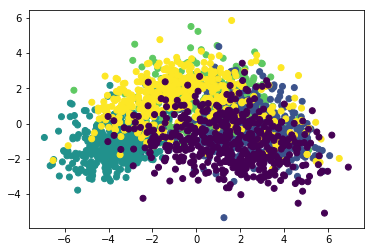

In [57]:
plt.scatter(df_km.iloc[:, 0], df_km.iloc[:, 1], c=df_km['genre'])
#plt.xlim([-6, 7])
#plt.ylim([-5, 7])
plt.show()

#### GRAFICAMOS CADA SUBGRUPO DE CLASES CON EL MEJOR CLUSTERING ENCONTRADO (DF)

Text(0.5, 1.0, "['world-music']")

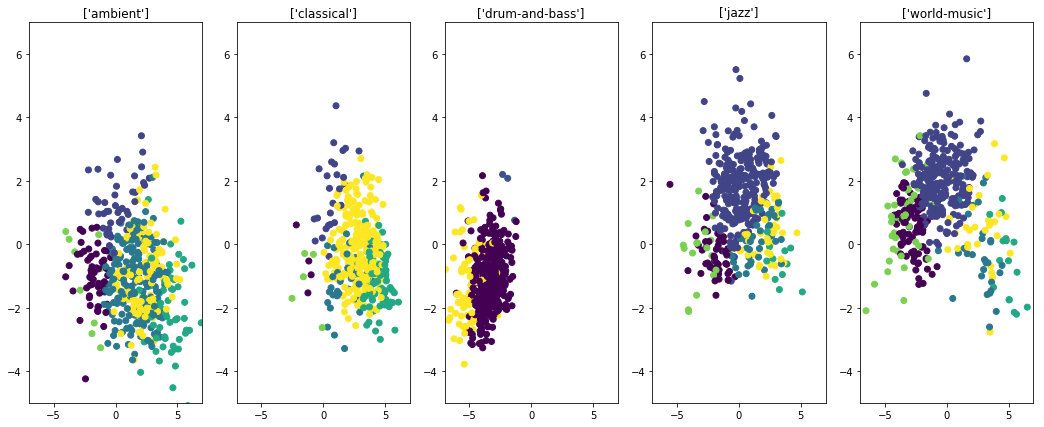

<Figure size 432x288 with 0 Axes>

In [58]:
fig, (g1, g2, g3, g4,g5) = plt.subplots(1, 5)
fig.set_size_inches(18, 7)    

plt.figure()
g1.scatter(df_km[df_km['genre']==0].iloc[:, 0], df_km[df_km['genre']==0].iloc[:, 1], c=df_km[df_km['genre']==0]['label'])
g1.set_xlim([-7, 7])
g1.set_ylim([-5, 7])
g1.set_title(le.inverse_transform([0]))
g2.scatter(df_km[df_km['genre']==1].iloc[:, 0], df_km[df_km['genre']==1].iloc[:, 1], c=df_km[df_km['genre']==1]['label'])
g2.set_xlim([-7, 7])
g2.set_ylim([-5, 7])
g2.set_title(le.inverse_transform([1]))
g3.scatter(df_km[df_km['genre']==2].iloc[:, 0], df_km[df_km['genre']==2].iloc[:, 1], c=df_km[df_km['genre']==2]['label'])
g3.set_xlim([-7, 7])
g3.set_ylim([-5, 7])
g3.set_title(le.inverse_transform([2]))
g4.scatter(df_km[df_km['genre']==3].iloc[:, 0], df_km[df_km['genre']==3].iloc[:, 1], c=df_km[df_km['genre']==3]['label'])
g4.set_xlim([-7, 7])
g4.set_ylim([-5, 7])
g4.set_title(le.inverse_transform([3]))
g5.scatter(df_km[df_km['genre']==4].iloc[:, 0], df_km[df_km['genre']==4].iloc[:, 1], c=df_km[df_km['genre']==4]['label'])
g5.set_xlim([-7, 7])
g5.set_ylim([-5, 7])
g5.set_title(le.inverse_transform([4]))

### Ahora procedemos a realizar un cluster jerarquico y realizar las medidas de similaridad

In [26]:
dataframes = ['af_std','aa_std','df']
princomp = PCA(n_components=2)
resultjer = {}
for data in dataframes:
    jerarquico = AgglomerativeClustering(n_clusters=5, affinity='euclidean', linkage='ward')
    jerarquico.fit_predict(eval(data))
    label = jerarquico.labels_
    pca = princomp.fit(eval(data)).transform(eval(data))
    pca = pd.DataFrame(pca)
    pca.index = eval(data).index
    pca['label'] = label
    resultjer[data]=pca
    

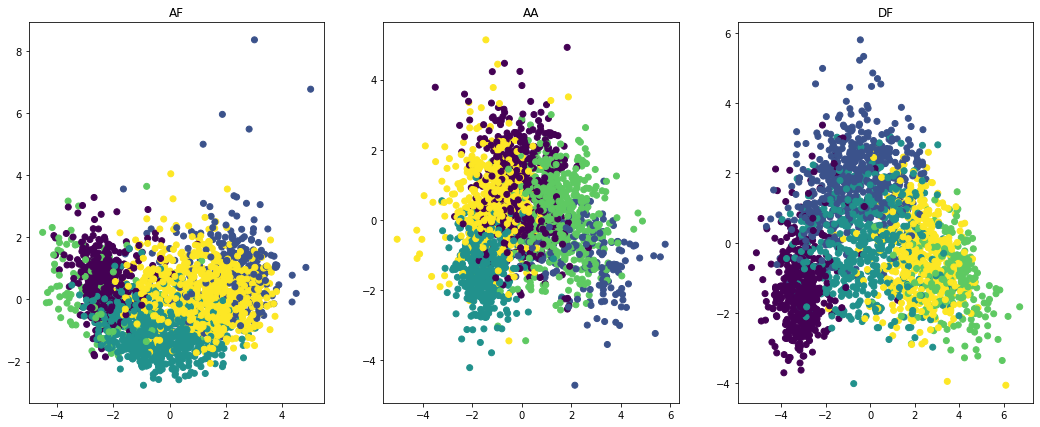

<Figure size 432x288 with 0 Axes>

In [27]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.scatter(resultjer['af_std'].iloc[:, 0], resultjer['af_std'].iloc[:, 1], c=resultjer['af_std'].iloc[:, 2])
g2.scatter(resultjer['aa_std'].iloc[:, 0], resultjer['aa_std'].iloc[:, 1], c=resultjer['aa_std'].iloc[:, 2])
g3.scatter(resultjer['df'].iloc[:, 0], resultjer['df'].iloc[:, 1], c=resultjer['df'].iloc[:, 2])
g1.set_title("AF")
g2.set_title("AA")
g3.set_title("DF")
plt.show()

Calculamos el coef. Hopkins para los datasets


Calculamos el coef. Van Dongen para los datasets

Si bien el metodo de Van Dongen esta pensado para una validación externa contra una clase, en este caso lo usaremos para comparar cuan proximos estan los clusters arrojados por los datasets Audio Feature / Audio Analysis.

In [28]:
def vanDongen(ct):

    n2=2*(sum(ct.apply(sum,axis=1)))

    sumi = sum(ct.apply(np.max,axis=1))

    sumj = sum(ct.apply(np.max,axis=0))

    maxsumi = np.max(ct.apply(sum,axis=1))

    maxsumj = np.max(ct.apply(sum,axis=0))

    vd = (n2 - sumi - sumj)/(n2 - maxsumi - maxsumj)

    return vd



af_jer = resultjer['af_std']

aa_jer = resultjer['aa_std']

df_jer = resultjer['df']



af_jer=af_jer[af_jer.index.isin(df_jer.index)]

aa_jer=aa_jer[aa_jer.index.isin(df_jer.index)]



df_jer['lab_af']=af_jer['label']

df_jer['lab_aa']=aa_jer['label']



ct1jer = pd.crosstab(df_jer['label'], df_jer['lab_af'])

ct2jer = pd.crosstab(df_jer['label'], df_jer['lab_aa'])

ct3jer = pd.crosstab(df_jer['lab_af'], df_jer['lab_aa'])

ct2jer

lab_aa,0,1,2,3,4
label,,,,,
0,21,1,376,1,69
1,214,1,24,38,267
2,199,19,32,103,160
3,12,138,0,65,0
4,79,29,1,349,6


In [29]:
print("Van Dongen DF vs AF:", vanDongen(ct1jer))

print("Van Dongen DF vs AA:", vanDongen(ct2jer))

print("Van Dongen AF vs AA:", vanDongen(ct3jer))

Van Dongen DF vs AF: 0.5187235428199284
Van Dongen DF vs AA: 0.5244860943168077
Van Dongen AF vs AA: 0.6734226871526643


Los resultados indican que el clustering DF y AA estan proximos entre si. Por otro lado los clustering de AA y AF distan bastante.

Calculamos indice de Rand

In [30]:
ari1jer = adjusted_rand_score(df_jer['label'], df_jer['lab_af'])

ari2jer = adjusted_rand_score(df_jer['label'], df_jer['lab_aa'])

ari3jer = adjusted_rand_score(df_jer['lab_af'], df_jer['lab_aa'])


print("Rand score DF vs AF:", ari1jer)

print("Rand score DF vs AA:", ari2jer)

print("Rand score AF vs AA:", ari3jer)

Rand score DF vs AF: 0.30860868237249345
Rand score DF vs AA: 0.32511555101755685
Rand score AF vs AA: 0.1755723767222908



Se observan la misma tendencia que Van Dongen
Realizamos calculo contra la clase

In [31]:

metadata_sub=metadata[metadata.index.isin(df_jer.index)]

from sklearn import preprocessing

le = preprocessing.LabelEncoder()

le.fit(metadata_sub['genre'])

df_jer['genre']=le.transform(metadata_sub['genre'])


ct_g1jer = pd.crosstab(df_jer['label'], df_jer['genre'])

ct_g2jer = pd.crosstab(df_jer['lab_af'], df_jer['genre'])

ct_g3jer = pd.crosstab(df_jer['lab_aa'], df_jer['genre'])


print("Van Dongen DF vs Genre:", vanDongen(ct_g1jer))

print("Van Dongen AF vs Genre:", vanDongen(ct_g2jer))

print("Van Dongen AA vs Genre:", vanDongen(ct_g3jer))

Van Dongen DF vs Genre: 0.5324904439870626
Van Dongen AF vs Genre: 0.6072335025380711
Van Dongen AA vs Genre: 0.5863086456181764


GRAFICAMOS LAS CLASES REALES EN EL MISMO ESPACIO TRANSFORMADO


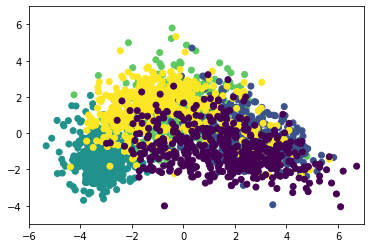

In [32]:
plt.scatter(df_jer.iloc[:, 0], df_jer.iloc[:, 1], c=df_jer['genre'])

plt.xlim([-6, 7])

plt.ylim([-5, 7])

plt.show()

GRAFICAMOS CADA SUBGRUPO DE CLASES CON EL MEJOR CLUSTERING ENCONTRADO (DF)


Text(0.5, 1.0, "['world-music']")

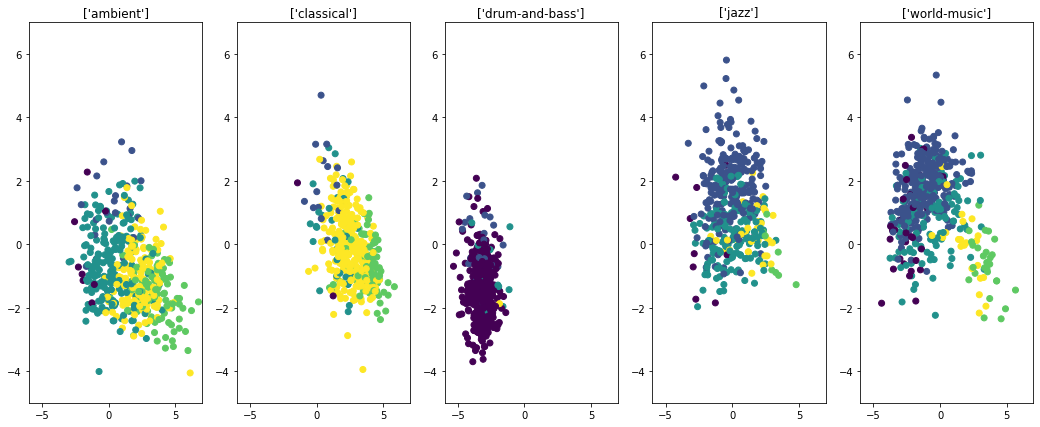

<Figure size 432x288 with 0 Axes>

In [33]:
fig, (g1, g2, g3, g4,g5) = plt.subplots(1, 5)

fig.set_size_inches(18, 7)    

plt.figure()

g1.scatter(df_jer[df_jer['genre']==0].iloc[:, 0], df_jer[df_jer['genre']==0].iloc[:, 1], c=df_jer[df_jer['genre']==0]['label'])

g1.set_xlim([-6, 7])

g1.set_ylim([-5, 7])

g1.set_title(le.inverse_transform([0]))

g2.scatter(df_jer[df_jer['genre']==1].iloc[:, 0], df_jer[df_jer['genre']==1].iloc[:, 1], c=df_jer[df_jer['genre']==1]['label'])

g2.set_xlim([-6, 7])

g2.set_ylim([-5, 7])

g2.set_title(le.inverse_transform([1]))

g3.scatter(df_jer[df_jer['genre']==2].iloc[:, 0], df_jer[df_jer['genre']==2].iloc[:, 1], c=df_jer[df_jer['genre']==2]['label'])

g3.set_xlim([-6, 7])

g3.set_ylim([-5, 7])

g3.set_title(le.inverse_transform([2]))

g4.scatter(df_jer[df_jer['genre']==3].iloc[:, 0], df_jer[df_jer['genre']==3].iloc[:, 1], c=df_jer[df_jer['genre']==3]['label'])

g4.set_xlim([-6, 7])

g4.set_ylim([-5, 7])

g4.set_title(le.inverse_transform([3]))

g5.scatter(df_jer[df_jer['genre']==4].iloc[:, 0], df_jer[df_jer['genre']==4].iloc[:, 1], c=df_jer[df_jer['genre']==4]['label'])

g5.set_xlim([-6, 7])

g5.set_ylim([-5, 7])

g5.set_title(le.inverse_transform([4]))

### Ahora procedemos a realizar un cluster por densidad OPTICS, el cual utiliza una optimizacion del DBSCAN y realizar las medidas de similaridad

In [39]:
from sklearn.cluster import OPTICS, cluster_optics_dbscan

dataframes = ['af_std','aa_std','df']
princomp = PCA(n_components=2)
resultopt = {}
for data in dataframes:
    optics = OPTICS(min_samples=50, xi=.05, min_cluster_size=.05)
    optics.fit_predict(eval(data))
    label = optics.labels_
    pca = princomp.fit(eval(data)).transform(eval(data))
    pca = pd.DataFrame(pca)
    pca.index = eval(data).index
    pca['label'] = label
    resultopt[data]=pca

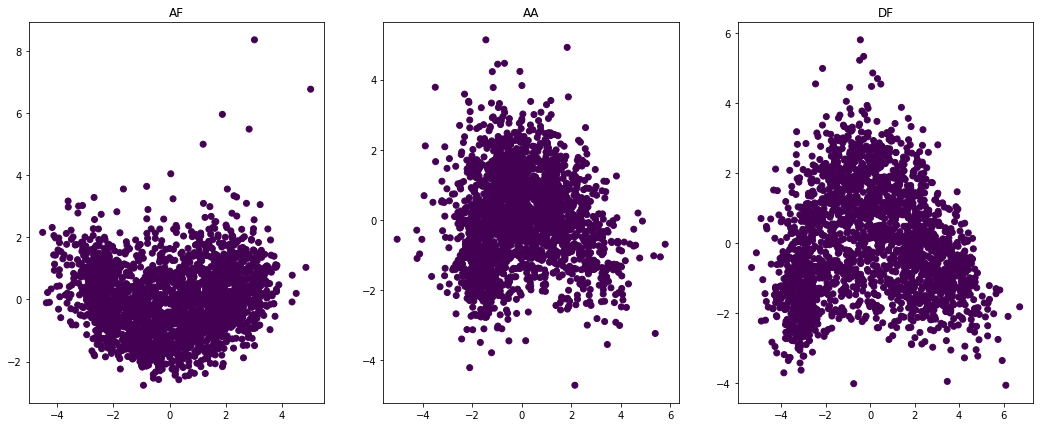

<Figure size 432x288 with 0 Axes>

In [40]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.scatter(resultopt['af_std'].iloc[:, 0], resultopt['af_std'].iloc[:, 1], c=resultopt['af_std'].iloc[:, 2])
g2.scatter(resultopt['aa_std'].iloc[:, 0], resultopt['aa_std'].iloc[:, 1], c=resultopt['aa_std'].iloc[:, 2])
g3.scatter(resultopt['df'].iloc[:, 0], resultopt['df'].iloc[:, 1], c=resultopt['df'].iloc[:, 2])
g1.set_title("AF")
g2.set_title("AA")
g3.set_title("DF")
plt.show()

# 5 - Procedemos aplicar otro tipo de filtro

Intentamos con RMS

In [73]:
items = []
items_1=[]
for i in range(0,len(audio_timbre)):
    items_1=np.transpose(pd.DataFrame(
                                        (np.sqrt(audio_timbre[i]**2)).mean()
                                        ))
    #items_1=np.transpose(pd.DataFrame(  audio_timbre[i].mean()  ))
    items.append(items_1)

audio_timbre_rms=pd.concat(items)

at_rms = audio_timbre_rms.apply(zscore)
at_rms.head()

,0,1,2,3,4,5,6,7,8,9,10,11
0,1.684559,0.496800,-0.410071,-0.862350,1.197278,0.110379,-0.914401,-0.268315,-1.034284,-0.318016,-0.003423,-0.986386
0,1.567751,0.181572,-0.855880,-1.298219,0.394912,1.202591,-0.736870,-0.598003,1.156023,-0.852571,-0.021365,-0.078337
0,-0.671032,-0.114989,-0.109400,-0.476245,0.275866,-0.749543,1.691793,-0.326590,1.085210,-0.621757,-0.237392,2.189036
0,-1.844885,0.996693,-0.486407,-0.529069,3.037021,-0.441184,0.237669,0.235984,1.160732,-1.012149,-1.161676,-0.316291
0,0.729677,-0.375134,0.239861,-0.602450,-0.087919,1.396036,0.495931,-0.361096,1.757410,-0.298421,-0.278138,-0.146604


In [77]:
dataframes = ['af_std','at_std','ap_std','at_rms','aa_std','df']
princomp = PCA(n_components=2)
result_rms = {}
for data in dataframes:
    kmeans = KMeans(n_clusters=6, init='random',n_init=5,max_iter=500, random_state=0)
    kmeans.fit(eval(data))
    label = kmeans.labels_
    pca = princomp.fit(eval(data)).transform(eval(data))
    pca = pd.DataFrame(pca)
    pca.index = eval(data).index
    pca['label'] = label
    result_rms[data]=pca
    

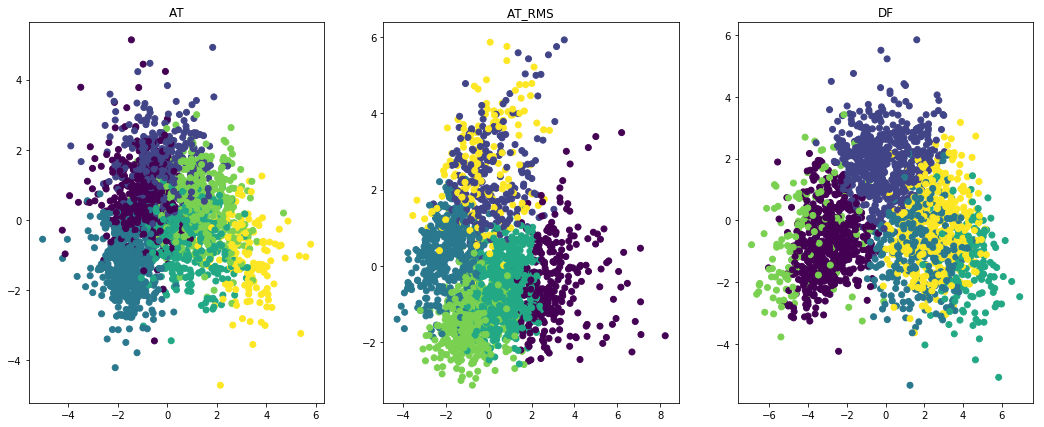

<Figure size 432x288 with 0 Axes>

In [79]:
fig, (g1, g2, g3) = plt.subplots(1, 3)
fig.set_size_inches(18, 7)    

plt.figure()
g1.scatter(result_rms['at_std'].iloc[:, 0], result_rms['at_std'].iloc[:, 1], c=result_rms['at_std'].iloc[:, 2])
g2.scatter(result_rms['at_rms'].iloc[:, 0], result_rms['at_rms'].iloc[:, 1], c=result_rms['at_rms'].iloc[:, 2])
g3.scatter(result_rms['df'].iloc[:, 0], result_rms['df'].iloc[:, 1], c=result_rms['df'].iloc[:, 2])
g1.set_title("AT")
g2.set_title("AT_RMS")
g3.set_title("DF")
plt.show()